In [61]:
import json
import uuid
import shapely
import numpy as np
import pyproj
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString
from shapely.ops import transform
from geojson import Point, Feature, FeatureCollection, dump

dir = "/Users/sebastian/Documents/SkiNavApp/"

In [62]:
gdf_runs = pd.read_pickle(dir+"runs_les_trois_vallee.pkl")
gdf_lifts = pd.read_pickle(dir+"lifts_les_trois_vallee.pkl")

# change to crs france UoM metric
features = ["id", "name", "resort_name", "connection_type", "difficulty",
            "duration", "distance", "geometry", "start", "end"]

gdf_runs = gdf_runs.to_crs("27561")
gdf_runs["uses"] = gdf_runs.uses.apply(lambda x: x[0])
gdf_runs["distance"] = gdf_runs.geometry.length
gdf_runs["start"] = gdf_runs.geometry.apply(lambda x: Point(x.coords[0]))
gdf_runs["end"] = gdf_runs.geometry.apply(lambda x: Point(x.coords[-1]))
gdf_runs["connection_type"] = "run"
gdf_runs["duration"] = gdf_runs["distance"] / 7 # 25km/h or 7m/s
gdf_runs = gdf_runs[gdf_runs.uses=="downhill"]
gdf_runs = gdf_runs[features]

# change to crs france UoM metric
gdf_lifts = gdf_lifts.to_crs("27561")
gdf_lifts["distance"] = gdf_lifts.geometry.length
gdf_lifts["start"] = gdf_lifts.geometry.apply(lambda x: Point(x.coords[0]))
gdf_lifts["end"] = gdf_lifts.geometry.apply(lambda x: Point(x.coords[-1]))
gdf_lifts["geometry"] = gdf_lifts.geometry.apply(lambda x: LineString([x.coords[0], x.coords[-1]]))
gdf_lifts["connection_type"] = "lift"
gdf_lifts = gdf_lifts.rename(columns={"liftType": "lift_type"})
gdf_lifts.head()
gdf_lifts["difficulty"] = "lift"
mean_speed = gdf_lifts[gdf_lifts["duration"].notnull()]["distance"].sum() / gdf_lifts[gdf_lifts["duration"].notnull()].duration.sum()
gdf_lifts["duration"] = np.where(gdf_lifts["duration"].isna(), (gdf_lifts["distance"] / mean_speed), gdf_lifts["duration"])
gdf_lifts = gdf_lifts[features]

data = pd.concat([gdf_lifts, gdf_runs])

<Axes: >

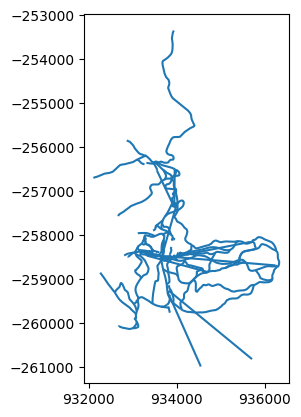

In [63]:
# set data area
test_data = data.copy()
#test_data = test_data[test_data["name"].isin(["Béranger", "Lac Blanc", "Tête Ronde", "Croissant",
#                                    "Trolles", "Adrien Théaux", "Ardoises", "Boulevard Lauzes",
#                                    "Dalles", "Stade", "Corniche", "Roc", "Christine",
#                                    "Cascades", "Funitel Péclet", "Pionniers", "Plein Sud", "Vires",
#                                    "Bleuets", "2 Combes", "Flocon", "Combe de Thorens"])]
test_data = test_data[~((test_data["name"].isin(["Stade"])) & (test_data.connection_type=="lift")) & (test_data.geometry.apply(lambda x: x.coords[0][1]) < -256000) & (test_data.geometry.apply(lambda x: x.coords[0][1]) > -260000) & (test_data.geometry.apply(lambda x: x.coords[0][0]) > 933000)]
test_data = test_data[~test_data.id.isin(["4c8d28e91232c0842a7ee27b6b688f83e36871c1", "8ca54533ba58833bb34bf182c41401bcc6ff564e"])]
test_data.geometry.plot()

In [64]:
points = test_data.geometry.apply(lambda x: x.coords).rename("point").explode().reset_index().rename(columns={"index": "Index"})
test_data = test_data.reset_index().rename(columns={"index": "Index"})

unique_id = []
for i in range(len(points)):
    unique_id.append(str(uuid.uuid4()))

points["point_id"] = unique_id
points = points.merge(test_data[["id", "name", "Index", "difficulty", "duration", "distance", "connection_type", "start", "end"]], how="left", on="Index")
points = gpd.GeoDataFrame(points, geometry=[Point(x) for x in points.point]).rename(columns={"id": "run_id"})

In [65]:
start_points = points.groupby("run_id").first().reset_index()
start_points["point_type"] = "start"
end_points = points.groupby("run_id").last().reset_index()
end_points["point_type"] = "end"
start_end_points = pd.concat([start_points, end_points], axis=0).sort_values(by="run_id")
points["points_by_run"] = points.groupby("run_id").point_id.transform("count")

In [66]:
# create runsliftsgraph

runsliftsgraph = []
run_id_tmp = points.run_id.iloc[0]
run_tmp = []
counter = 1

for run_id, run_name, point_id, points_by_run, point_coord, connection_type, distance, duration, difficulty in list(zip(points.run_id, points["name"], points.point_id, points.points_by_run, points.geometry, points.connection_type, points["distance"], points.duration, points.difficulty)):
    if counter < points_by_run:
        run_tmp.append({
            "point_id": point_id,
            "connection_type": connection_type,
            "distance": distance,
            "duration": duration,
            "difficulty": difficulty,
            "run_name": run_name,
            "type": "point",
            "point_coord": point_coord
        })
        counter += 1

    elif counter == points_by_run:
        run_tmp.append({
            "point_id": point_id,
            "connection_type": connection_type,
            "distance": distance,
            "duration": duration,
            "difficulty": difficulty,
            "run_name": run_name,
            "type": "point",
            "point_coord": point_coord
        })
        runsliftsgraph.append({run_id: run_tmp})

        run_tmp = []
        counter = 1

In [67]:
def find_matches(graph, id):
    matches = []
    for run in graph:
        for point in list(run.values())[0]:
            if point.get("point_id") == id:
                matches.append(point)

    return matches

In [68]:
# get connected points and assing new unique node it

def replace_point_id(graph, old_id, new_id):
    for run in graph:
        for point in list(run.values())[0]:
            if point.get("point_id") == old_id:
                point["point_id" ] = new_id
                point["type" ] = "node"
    return graph

buffer_zone = 2

for run_id, point_id_se, point_type_se, coords_se, difficulty_se, duration_se, connection_type_se, name_se in list(zip(start_end_points.run_id, start_end_points.point_id ,start_end_points.point_type, start_end_points.geometry, start_end_points.difficulty, start_end_points.duration, start_end_points.connection_type, start_end_points["name"])):
    matching_runs = []
    connected_runs = []
    for RunLift in runsliftsgraph:
        points_in_buffer = []
        candidate_run_id = list(RunLift.keys())[0]
        # exclude points on same run
        if run_id != candidate_run_id and candidate_run_id not in connected_runs: 
            for point in list(RunLift.values())[0]:
                distance_to_point = coords_se.distance(point.get("point_coord"))
                if point_id_se != point.get("point_id") and distance_to_point <= buffer_zone:
                    points_in_buffer.append({"point_id": point.get("point_id"),
                                            "distance": distance_to_point})
                        
            # find closest point within buffer zone of specific run 
            Min = 10000
            for point_buffer in points_in_buffer:
                if point_buffer.get("distance") < Min:
                    Min = point_buffer.get("distance")
                    point_id = point_buffer.get("point_id")

            if len(points_in_buffer) > 0:
                matching_runs.append(point_id) # append matches
                connected_runs.append(candidate_run_id)

    # replacing matching points with new node id
    if len(matching_runs) > 0: # matches found
        node_id = str(uuid.uuid4())
        # replace matching points id
        for match in matching_runs:
            replace_point_id(runsliftsgraph, match, node_id)
        # replace start/end point id
        replace_point_id(runsliftsgraph, point_id_se, node_id)


In [69]:
# create RunsLiftsGraph
RunsLiftsGraph = {}

for run in runsliftsgraph:
    runlift = {}
    point_ids = []
    run_id = list(run.keys())[0]
    points = list(run.values())[0]
    for point in points:
        point_ids.append(point.get("point_id"))

    runlift["run_name"] = points[0].get("run_name")
    runlift["connection_type"] = points[0].get("connection_type")
    runlift["difficulty"] = points[0].get("difficulty")
    runlift["duration"] = points[0].get("duration")
    runlift["point_ids"] = point_ids

    RunsLiftsGraph[run_id] = runlift

# create LocationGraph
LocationGraph = {}

project = pyproj.Transformer.from_proj(
    pyproj.Proj(init='epsg:27561'), # source
    pyproj.Proj(init='epsg:4326')) # destination

for run in runsliftsgraph:
    points = list(run.values())[0]
    for point in points:
        point_wgs = transform(project.transform, point.get("point_coord"))
        LocationGraph[point.get("point_id")] = (point_wgs.coords[0][0], point_wgs.coords[0][1], point_wgs.coords[0][2])


/Users/sebastian/VirtualEnvironments/SkiNavApp/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/sebastian/VirtualEnvironments/SkiNavApp/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


<Axes: >

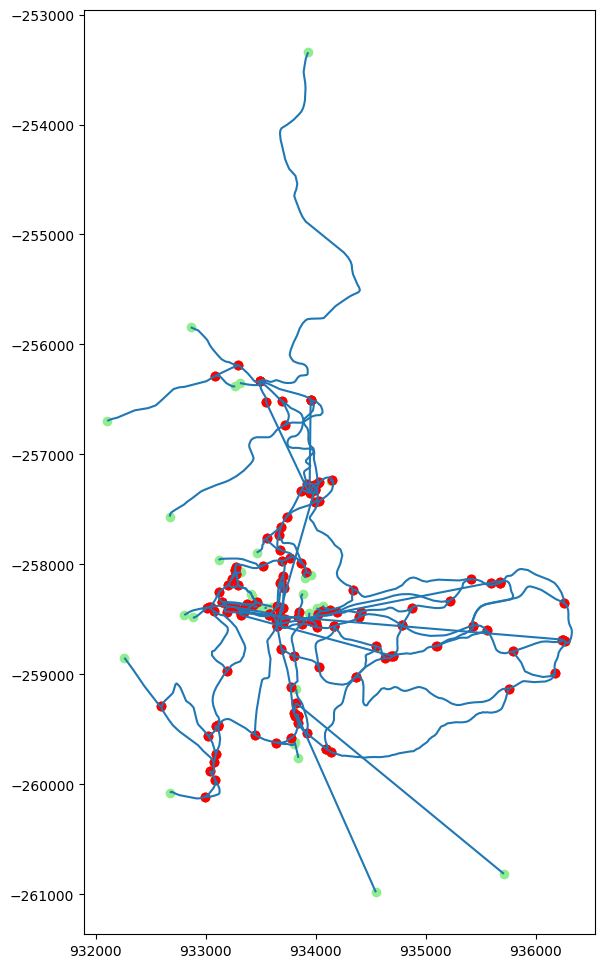

In [58]:
geo_data = sum([[y.get("point_coord") for y in list(x.values())[0] if y.get("type")=="node"] for x in runsliftsgraph], [])

fig, ax = plt.subplots(figsize=(10,12))
test_data.geometry.plot(ax=ax)
start_end_points.geometry.plot(ax=ax, color="lightgreen")
gpd.GeoDataFrame(geo_data, geometry=geo_data).plot(ax=ax, color="red")

In [71]:
# iterate through RunLifts, calculate segment length and keep nodes, start and end points

RunsLiftsNodesGraph = []

for RunLift in runsliftsgraph:
    first_point = True
    point_counter = 0
    run_coords = []
    run_tmp = []
    last_point = len(list(RunLift.values())[0])
    for point in list(RunLift.values())[0]:
        point_counter += 1
        
        # cache start point
        if first_point == True:
            start_tmp = {"point_id": point.get("point_id"),
                         "connection_type": point.get("connection_type"),
                         "distance": point.get("distance"),
                         "duration": point.get("duration"),
                         "difficulty": point.get("difficulty"),
                         "run_name": point.get("run_name"),
                         "type": point.get("type"),
                         "point_coord": point.get("point_coord")} 


        #pointer_start = 1 # reset pointer
        run_coords.append(point.get("point_coord"))

        # reached next node or last point, calculate run length
        if (point.get("type") == "node" or point_counter == last_point) and first_point != True:
            length_segment = LineString(run_coords).length
            start_tmp["distance"] = length_segment 
            start_tmp["distance_prop"] = length_segment / point.get("distance")
            run_tmp.append(start_tmp)
            run_coords = [] # reset run
            run_coords.append(point.get("point_coord")) # set new start point
            start_tmp = {"point_id": point.get("point_id"),
                         "connection_type": point.get("connection_type"),
                         "distance": point.get("distance"),
                         "duration": point.get("duration"),
                         "difficulty": point.get("difficulty"),
                         "run_name": point.get("run_name"),
                         "type": point.get("type"),
                         "point_coord": point.get("point_coord")}
        else:
            first_point = False

        # add last point
        if point_counter == last_point:
            run_tmp.append({"point_id": point.get("point_id"),
                            "connection_type": point.get("connection_type"),
                            "distance": 0.0,
                            "difficulty": point.get("difficulty"),
                            "run_name": point.get("run_name"),
                            "type": "end",
                            "point_coord": point.get("point_coord"),
                            "distance_prop": 0.0}) 


    # append modified run
    RunsLiftsNodesGraph.append({list(RunLift.keys())[0]: run_tmp})

<Axes: >

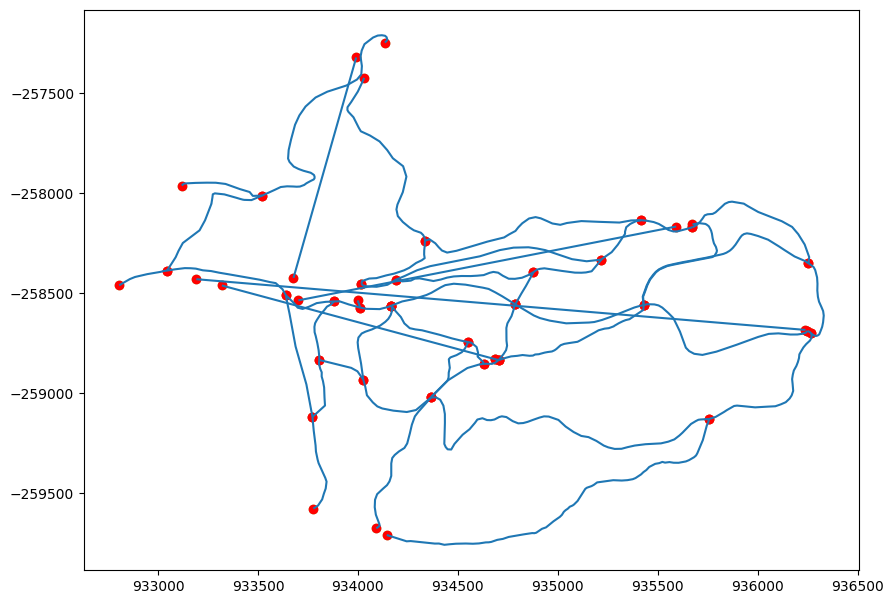

In [11]:
geo_data = sum([[y.get("point_coord") for y in list(x.values())[0]] for x in RunsLiftsNodesGraph], [])

fig, ax = plt.subplots(figsize=(10,12))
test_data.geometry.plot(ax=ax)
start_end_points.geometry.plot(ax=ax, color="lightgreen")
gpd.GeoDataFrame(geo_data, geometry=geo_data).plot(ax=ax, color="red")

In [72]:
# create NodeGraph

def to_edge(node):
    edge = {
        "duration": node.get("duration"),
        "difficulty": node.get("difficulty"),
        "distance_prop": node.get("distance_prop")
    }
    return edge


def get_matching_nodes(graph, connections, used_nodes, node_id):
    for runlift in graph:
        runlift = list(runlift.values())[0]

        position_counter = 0
        n_nodes = len(runlift)-1
        for node in runlift:
            # matching point_id, not last element of run, and not already appended
            if node.get("point_id") == node_id and position_counter < n_nodes and node.get("point_id") not in used_nodes:
                connections[runlift[position_counter+1].get("point_id")] = to_edge(node)

            position_counter += 1
            
    return connections


NodesGraph = {}
used_nodes = []

for RunLift in RunsLiftsNodesGraph:
    nodes = list(RunLift.values())[0]
    connections = {}

    for node in nodes:
        connections = get_matching_nodes(RunsLiftsNodesGraph, connections, used_nodes, node.get("point_id"))
        NodesGraph[node.get("point_id")] = connections
        used_nodes.append(node.get("point_id"))

In [73]:
with open ("LocationGraph.json", "w") as file:
    file.write(json.dumps(LocationGraph))

with open ("RunsLiftsGraph.json", "w") as file:
    file.write(json.dumps(RunsLiftsGraph))

with open ("NodesGraph.json", "w") as file:
    file.write(json.dumps(NodesGraph))

In [44]:
def weighter(edge: dict, weights: dict) -> dict: 
    """
    weights of format:
    {
        "lift": float,
        "novice": float,
        "easy": float,
        "intermediate": float,
        "advanced": float
    }
    returns the node weight as float
    """
    weight = 1 # default weight
    weight = weights.get(edge.get("difficulty"))
    weight = edge.get("duration") * edge.get("distance_prop") * weight

    return weight


In [46]:
test = NodesGraph.get("c96e9811-ca54-4009-b168-1cf80135f1ed").get("d68f5000-7b98-4edc-b707-3f059f5f6139")
test

{'duration': 285.0, 'difficulty': 'lift', 'distance_prop': 0.9999999968674417}